##### Install libraries

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve, auc, accuracy_score, precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
#import gensim.downloader as api
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
#from preprocessing import clean_text, remove_stopwords
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification, Trainer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, TrainingArguments
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
import torch
from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset
import openai
from collections import defaultdict
from sklearn.utils import shuffle
import os
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_df = pd.DataFrame(data=train_data).reset_index(drop=True)
test_df = pd.DataFrame(data=test_data).reset_index(drop=True)

In [ ]:
label_count = train_df["label"].value_counts()
label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

label_distribution = {label_map[i]: int(count) for i, count in label_count.items()}

### 2. Corpus Split

To properly evaluate the performance of my models and control overfitting, we split the dataset into three parts: **training**, **validation**, and **test** sets.

- **Training set (`X_train`, `y_train`)**: Used to train the model — it learns patterns from this data.

- **Validation set (`X_val`, `y_val`)**: Used during the training process to evaluate the model’s performance on data it hasn’t seen during training. This allows us to tune hyperparameters, monitor overfitting, and ensure the model generalizes well.

- **Test set (`X_test`, `y_test`)**: This is kept **completely untouched** until the end. It is only used once all model training and selection are complete, to fairly evaluate the final performance of the model on truly unseen data — simulating a real-world deployment scenario.


In [ ]:
# Step 1: Split into train + temp (temp will later be split into val and test)
X_train_all, X_test, y_train_all, y_test = train_test_split(
    train_df['text'], train_df['label'],
    test_size=0.20,  # 20% for test
    random_state=42,
    stratify=train_df['label']
)

# Step 2: Split temp into train and val (from the remaining 80%, take 20% for val => 0.2 * 0.8 = 0.16 total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.20,  # 20% of 80% = 16% of original data
    random_state=42,
    stratify=y_train_all
)

#X_test = test_df['text']

We use this data split differently depending on the modeling approach:

- **Pretrained Transformer Models + Fine-Tuning (e.g., FinBERT variants)**  
  These models require a lot of computational power and time to train.  
  For this reason, we use **just one partition** (`X_train` and `X_val`) during training and validation.  
  The test set remains untouched for final evaluation.

- **Traditional ML Models with Embedding + Classifier (e.g., MPNet + SVM, MiniLM + MLP)**  
  Since these models train much faster, we apply **10-fold cross-validation** using `X_train_all` and `y_train_all` to obtain more reliable performance estimates.  
  This means the validation is built into the folds, and we do **not use the explicit `X_val` in this case**.  
  We use this setup to **evaluate different embedding models and classifiers**, and to **tune hyperparameters for the best-performing combinations**.

- **Generative AI (ChatGPT Classification using Few-Shot Prompting)**  
 This approach does **not involve training at all**. It uses pre-defined labeled examples (few-shot) available from the training set (we chose **10 examples per class**), and directly prompts ChatGPT to classify new tweets.  
  Therefore, it is evaluated **only on the final test set (`X_test`, `y_test`)** to measure performance.



---

### Summary

| Approach                        | Training Set         | Validation Set     | Cross-Validation | Test Set Used |
|-------------------------------|----------------------|--------------------|------------------|---------------|
| Fine-Tuning Transformer Models | `X_train`            | `X_val`            | NO              | YES            |
| Embeddings + Classifier        | `X_train_all`        | YES (in folds)      | YES               | YES          |
| ChatGPT Few-Shot Classification| NO      | NO                | NO               | YES             |

This structured approach ensures that we balance computational efficiency with rigorous evaluation — always using the test set only once for a final, honest performance check.


### 3. Data Preprocessing

In [ ]:
stop=set(stopwords.words('english'))
lemma=WordNetLemmatizer()
stemmer=SnowballStemmer('english')


In [ ]:
def clean_tweet(text, lemmatize=False, stem=False, remove_stopwords=False, remove_punct=False):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags but keep the word
    text = re.sub(r'#', '', text)
    # Remove emojis and non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove punctuation (optional)

    if remove_punct:
      text = re.sub(r'[^\w\s]', '', text)

    tokens=word_tokenize(text)

    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop]
    if lemmatize:
        tokens = [lemma.lemmatize(token) for token in tokens]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]


    return ' '.join(tokens)


In [ ]:
# Training
X_train = X_train.apply(lambda x: clean_tweet(x, lemmatize=False, stem=False, remove_stopwords=False, remove_punct=False))
X_train_all = X_train_all.apply(lambda x: clean_tweet(x, lemmatize=False, stem=False, remove_stopwords=False, remove_punct=False))
# Validation
X_val =  X_val.apply(lambda x: clean_tweet(x, lemmatize=False, stem=False, remove_stopwords=False, remove_punct=False))
X_test = X_test.apply(lambda x: clean_tweet(x, lemmatize=False, stem=False, remove_stopwords=False, remove_punct=False))

__`URLs, Mentions, Hashtags, and Emojis Removed`__:
These are typically noisy and don’t add much semantic value, so we stripped them while keeping the core content intact.

__`No Lemmatization or Stemming`__:
Since we are using powerful pretrained models like FinBERT or MPNet that understand words in context and use subword tokenization, there's no need to simplify words. This helps preserve financial terms or slang as they appear.

__`No Stopword Removal`__:
Stopwords can carry important information, especially in sentiment and financial context.

__`No Punctuation Removal`__:
Punctuation was retained to preserve the tone or emphasis of a tweet (e.g., “??”, “!!”), which can be essential in interpreting sentiment.

By keeping the tweets structurally intact — while removing truly noisy elements like URLs and emojis — we allow the models to take full advantage of the rich contextual signals embedded in the language.

### 4. Using Pretrained Large Languages Model for Embeddings + Train a Classifier

In this section, we explore combining **pretrained sentence embeddings** with traditional **supervised classifiers** like Logistic Regression, SVM, and MLP.

In this approach we :

1. **Use a pretrained sentence transformer** (e.g., MPNet, MiniLM, E5-Base) to convert tweets into dense, fixed-size vector embeddings.
2. **Train a lightweight classifier** (e.g., Logistic Regression, SVM, MLP) on these embeddings to predict sentiment labels.
3. **Evaluate performance using 10-fold cross-validation** to ensure robust, reliable metrics.

We apply **10-fold cross-validation** using `StratifiedKFold` to split the training data. Each fold calls the function `evaluate_fold`, which performs:

1.**Embedding**: Encodes tweets using the selected sentence transformer.
2. **Training**: Fits a classifier on the training split.
3. **Evaluation**: Calculates metrics on both the training and test splits (per fold)

We track the following metrics:
- Precision, Recall, and F1-score for both training and test sets. we also track embedding dimensionality (to compare feature sizes).


In [ ]:
def get_folds(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    return list(skf.split(X, y))

#### 4.1 Using all-MiniLM-L6-v2, MPNet, Paraphrase-MiniLM and E5-Base

In [ ]:
embedding_models = {
    "MiniLM": "all-MiniLM-L6-v2",
    "MPNet": "all-mpnet-base-v2",
    "Paraphrase-MiniLM": "paraphrase-MiniLM-L6-v2",
    "E5-Base": "intfloat/e5-base-v2"

}

- Setting the classifiers

In [ ]:

classifiers = {
    "LogisticRegression": lambda: LogisticRegression(max_iter=1000),
    "SVM": lambda: SVC(kernel='linear', probability=True),
    "MLP": lambda: MLPClassifier(hidden_layer_sizes=(128,), max_iter=1000, random_state=42)
}

- Encoding the data

In [ ]:
def embed_all_sets(model, X_train, X_val, X_test):
    X_train_vec = model.encode(X_train.tolist(), show_progress_bar=True)
    X_val_vec = model.encode(X_val.tolist(), show_progress_bar=True)
    X_test_vec = model.encode(X_test.tolist(), show_progress_bar=True)
    return X_train_vec, X_val_vec, X_test_vec

- Training the models

In [ ]:
def evaluate_fold(X_train, y_train, X_test, y_test, fold_idx, embedding_models, classifiers):
    fold_results = []

    for emb_name, emb_path in embedding_models.items():
        print(f"\n  Embedding: {emb_name}")
        embed_model = SentenceTransformer(emb_path)

        X_train_vec = embed_model.encode(X_train.tolist(), show_progress_bar=False)
        X_test_vec = embed_model.encode(X_test.tolist(), show_progress_bar=False)
        n_features = X_train_vec.shape[1]

        for clf_name, clf_constructor in classifiers.items():
            print(f"    Classifier: {clf_name}")
            clf = clf_constructor()
            clf.fit(X_train_vec, y_train)
            y_pred = clf.predict(X_test_vec)

            # Train predictions and metrics
            y_train_pred = clf.predict(X_train_vec)
            train_report = classification_report(y_train, y_train_pred, target_names=labels, output_dict=True)

            # Test predictions and metrics
            y_test_pred = clf.predict(X_test_vec)
            test_report = classification_report(y_test, y_test_pred, target_names=labels, output_dict=True)

            fold_results.append({
                "fold": fold_idx,
                "embedding": emb_name,
                "classifier": clf_name,
                "n_features": n_features,
                "train_precision": train_report["weighted avg"]["precision"],
                "train_recall": train_report["weighted avg"]["recall"],
                "train_f1": train_report["weighted avg"]["f1-score"],
                "test_precision": test_report["weighted avg"]["precision"],
                "test_recall": test_report["weighted avg"]["recall"],
                "test_f1": test_report["weighted avg"]["f1-score"],
                "test_accuracy": test_report["accuracy"]
            })

    return fold_results

In [ ]:
def run_fold_evaluation(X, y, folds, embedding_models, classifiers):
    all_results = []

    for fold_idx, (train_idx, test_idx) in enumerate(folds, 1):
        print(f"\n===== Fold {fold_idx} =====")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        fold_results = evaluate_fold(X_train, y_train, X_test, y_test, fold_idx, embedding_models, classifiers)
        all_results.extend(fold_results)

    return pd.DataFrame(all_results)

In [ ]:
y_test

,label
4693,2
1599,2
9238,1
122,0
2475,1
...,...
7131,2
34,0
7109,2
5855,2


In [ ]:
folds = get_folds(X_train_all, y_train_all, n_splits=10)
df_results = run_fold_evaluation(X_train_all, y_train_all, folds, embedding_models, classifiers)


===== Fold 1 =====

  Embedding: MiniLM
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: MPNet
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: Paraphrase-MiniLM
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: E5-Base
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

===== Fold 2 =====

  Embedding: MiniLM
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: MPNet
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: Paraphrase-MiniLM
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: E5-Base
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

===== Fold 3 =====

  Embedding: MiniLM
    Classifier: LogisticRegression
    Classifier: SVM
    Classifier: MLP

  Embedding: MPNet
    Classifier: LogisticRegression

- Visualizing the average result per fold

In [ ]:

df_avg_results = df_results.groupby(["embedding", "classifier", "n_features"]).agg({
    "test_precision": "mean",
    "test_recall": "mean",
    "test_f1": "mean",
    "test_accuracy": "mean"
}).reset_index()

df_avg_results = df_avg_results.sort_values(by="test_f1", ascending=False)
df_avg_results

,embedding,classifier,n_features,test_precision,test_recall,test_f1,test_accuracy
1,E5-Base,MLP,768,0.844889,0.844114,0.844029,0.844114
2,E5-Base,SVM,768,0.843386,0.845294,0.840389,0.845294
4,MPNet,MLP,768,0.839335,0.841229,0.839530,0.841229
0,E5-Base,LogisticRegression,768,0.841008,0.842541,0.836950,0.842541
3,MPNet,LogisticRegression,768,0.832785,0.835599,0.831024,0.835599
5,MPNet,SVM,768,0.830205,0.832848,0.828729,0.832848
10,Paraphrase-MiniLM,MLP,384,0.807691,0.811367,0.808297,0.811367
7,MiniLM,MLP,384,0.798458,0.801282,0.799156,0.801282
9,Paraphrase-MiniLM,LogisticRegression,384,0.786472,0.792503,0.787246,0.792503
11,Paraphrase-MiniLM,SVM,384,0.782567,0.788573,0.783593,0.788573


- plotting the distribution of results

In [ ]:
df_results["Combination"] = df_results["embedding"] + " + " + df_results["classifier"]
df_melted = df_results.melt(
    id_vars=["Combination", "fold"],
    value_vars=["train_f1", "test_f1"],
    var_name="Set",
    value_name="F1-score"
)
df_melted["Set"] = df_melted["Set"].map({
    "train_f1": "Train",
    "test_f1": "Test"
})

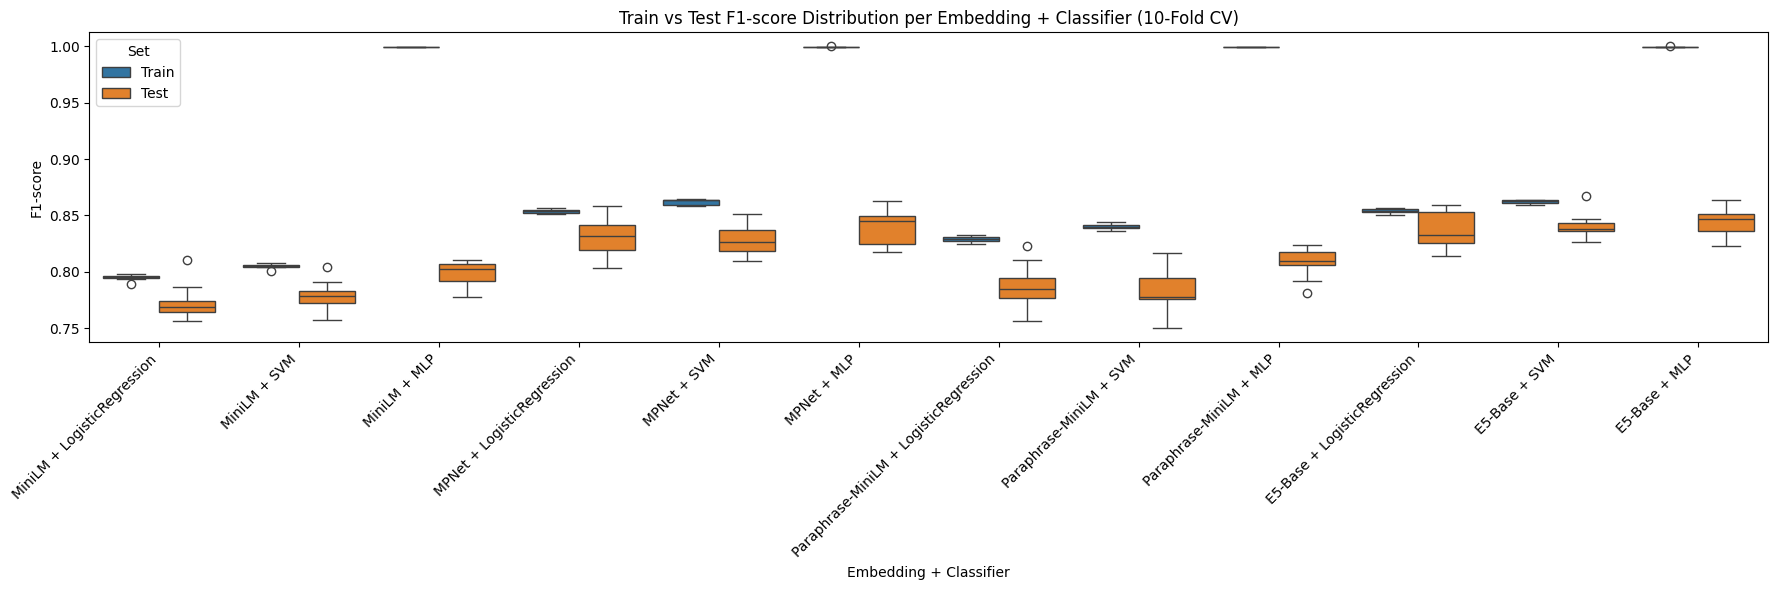

In [ ]:

plt.figure(figsize=(18, 6))
sns.boxplot(x="Combination", y="F1-score", hue="Set", data=df_melted)
plt.xticks(rotation=45, ha='right')
plt.title("Train vs Test F1-score Distribution per Embedding + Classifier (10-Fold CV)")
plt.xlabel("Embedding + Classifier")
plt.ylabel("F1-score")
plt.legend(title="Set")
plt.tight_layout()
plt.show()

- Higher-dimensional embeddings perform better
Models using MPNet and E5-Base (both 768-dimensional) generally outperform those using MiniLM or Paraphrase-MiniLM (384-dimensional). These richer embeddings provide the classifiers with more informative features, helping them learn better sentiment distinctions.

- MLP consistently overfits
The MLP (Neural Network) classifier shows extremely high training F1-scores (~1.0) across all embeddings, but lower test F1-scores, indicating overfitting.

- Despite overfitting, MLP achieves the highest test F1 overall
MPNet + MLP and E5-Base + MLP both achieve some of the highest test F1-score medians, indicating that despite the overfitting, MLP is still the best performer on average


To improve generalization and reduce overfitting, we'll perform hyperparameter tuning (using GridSearchCV) only on the best-performing combinations:MPNet + MLP and E5-Base + MLP

- Grid search parameters grid

In [ ]:
mlp_param_grid = {
    "hidden_layer_sizes":  [(32,),  (64,),   (100,)] ,
    "alpha": [1e-4, 1e-3, 1e-2],  # L2 regularization
    #"activation": ["relu"],
    "learning_rate_init": [0.001, 0.01]
}


In [ ]:
def fine_tune_mlp_with_embedding(X, y, emb_name, emb_path):
    print(f"\n Fine-tuning MLP with embedding: {emb_name}")
    embed_model = SentenceTransformer(emb_path)
    X_vec = embed_model.encode(X.tolist(), show_progress_bar=True)

    mlp = MLPClassifier(max_iter=500, random_state=42)
    scorer = make_scorer(f1_score, average="weighted")
    grid = GridSearchCV(
        mlp,
        param_grid=mlp_param_grid,
        cv=10,
        scoring=scorer,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    grid.fit(X_vec, y)
    print(f"\nBest parameters for {emb_name}: {grid.best_params_}")
    print(f"Best CV F1-score: {grid.best_score_:.4f}")
    cv_results_df = pd.DataFrame(grid.cv_results_)
    cv_results_df["embedding"] = emb_name
    return grid.best_estimator_, cv_results_df

In [ ]:
best_mlp_mpnet, df_grid_mpnet = fine_tune_mlp_with_embedding(X_train_all, y_train_all, "MPNet", embedding_models["MPNet"])
best_mlp_e5, df_grid_e5 = fine_tune_mlp_with_embedding(X_train_all, y_train_all, "E5-Base", embedding_models["E5-Base"])



 Fine-tuning MLP with embedding: MPNet


Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Fitting 10 folds for each of 18 candidates, totalling 180 fits

Best parameters for MPNet: {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Best CV F1-score: 0.8428

 Fine-tuning MLP with embedding: E5-Base


Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Fitting 10 folds for each of 18 candidates, totalling 180 fits

Best parameters for E5-Base: {'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best CV F1-score: 0.8500



Now we will retrain:

- **MPNet + MLP** using `{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}`  
- **E5-Base + MLP** using `{'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}`

Then we will evaluate both models on the test set (`X_test`, `y_test`) and compare their performance using the **classification report**.

- Defining the function the two functions to train for later use

In [ ]:
def predict_with_MPNet_MLP(X_train, y_train, X_test):
    embed_model = SentenceTransformer("all-mpnet-base-v2")
     # Encode the training and test data
    X_train_vec = embed_model.encode(X_train.tolist(), show_progress_bar=True)
    X_test_vec = embed_model.encode(X_test.tolist(), show_progress_bar=True)
    # Use MLP classifier
    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42, learning_rate_init= 0.001)
    clf.fit(X_train_vec, y_train)
    # Predict
    train_preds = clf.predict(X_train_vec)
    test_preds = clf.predict(X_test_vec)

    return train_preds, test_preds

In [ ]:
def predict_with_E5_base_MLP(X_train, y_train, X_test):
    embed_model = SentenceTransformer("intfloat/e5-base-v2")
     # Encode the training and test data
    X_train_vec = embed_model.encode(X_train.tolist(), show_progress_bar=True)
    X_test_vec = embed_model.encode(X_test.tolist(), show_progress_bar=True)
    # Use MLP classifier
    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42,learning_rate_init= 0.01)
    clf.fit(X_train_vec, y_train)
    # Predict
    train_preds = clf.predict(X_train_vec)
    test_preds = clf.predict(X_test_vec)

    return train_preds, test_preds

- Retraining on all training data:

In [ ]:
_, preds=predict_with_MPNet_MLP(X_train_all, y_train_all, X_test)
print(" Classificattion report for MPNET+MLP")
print(classification_report(y_test, preds, target_names=labels))


Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

 Classificattion report for MPNET+MLP
              precision    recall  f1-score   support

     Bearish       0.73      0.71      0.72       288
     Bullish       0.80      0.78      0.79       385
     Neutral       0.90      0.91      0.90      1236

    accuracy                           0.85      1909
   macro avg       0.81      0.80      0.80      1909
weighted avg       0.85      0.85      0.85      1909



In [ ]:
_, preds=predict_with_E5_base_MLP(X_train_all, y_train_all, X_test)
print(" Classificattion report for E5_Base+MLP")
print(classification_report(y_test, preds, target_names=labels))


Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

 Classificattion report for E5_Base+MLP
              precision    recall  f1-score   support

     Bearish       0.70      0.75      0.72       288
     Bullish       0.78      0.74      0.76       385
     Neutral       0.88      0.88      0.88      1236

    accuracy                           0.83      1909
   macro avg       0.79      0.79      0.79      1909
weighted avg       0.83      0.83      0.83      1909




After training both models with their best hyperparameters, we evaluated them on the test set (`X_test`, `y_test`). Below is a summary of the results.

| Metric               | MPNet + MLP | E5-Base + MLP |
|----------------------|-------------|----------------|
| **Accuracy**         | 0.85        | 0.83           |
| **Macro F1-score**   | 0.80        | 0.79           |
| **Weighted F1-score**| 0.85        | 0.83           |
|                      |             |                |
| **Bearish (F1)**     | 0.72        | 0.72           |
| **Bullish (F1)**     | 0.79        | 0.76           |
| **Neutral (F1)**     | 0.90        | 0.88           |

- **MPNet + MLP** performed slightly better overall, especially for the **Neutral** and **Bullish** classes.
- **E5-Base + MLP** had slightly better **recall for Bearish tweets**, but overall lower precision and F1-scores.
- MPNet had higher **accuracy and weighted average F1-score**, making it the better choice in this setup.

#### 4.2 Other experimentations

##### 4.2.1 Distilbert

In [ ]:
MODEL = "assemblyai/distilbert-base-uncased-sst2"

In [ ]:
def generate_cls_embeddings(texts, embedding_model, desc="Generating CLS Embeddings"):
  cls_embedding=[]
  for text in tqdm(texts, desc=desc):
    embedding=torch.tensor(embedding_model(text)[0][0])
    cls_embedding.append(embedding)
  return cls_embedding

In [ ]:
embeddings_model=pipeline("feature-extraction", model=MODEL, tokenizer=MODEL, device_map="cuda", truncation=True )
train_cls_embeddings=generate_cls_embeddings(X_train, embeddings_model)
val_cls_embeddings=generate_cls_embeddings(X_val, embeddings_model)

Device set to use cuda


Generating CLS Embeddings:   0%|          | 0/7634 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Generating CLS Embeddings:   0%|          | 0/1909 [00:00<?, ?it/s]

In [ ]:
torch.stack(train_cls_embeddings).shape

torch.Size([7634, 768])

In [ ]:
X_train_em=np.array(train_cls_embeddings)
X_val_em=np.array(val_cls_embeddings)
y_train=np.array(y_train)
y_val=np.array(y_val)

In [ ]:
clf=LogisticRegression(max_iter=500)
clf.fit(X_train_em, y_train)

LogisticRegression(max_iter=500)

In [ ]:
y_pred=clf.predict(X_val_em)

In [ ]:
labels={ "Bearish":0,  "Bullish":1, "Neutral":2}
print(classification_report(y_val,y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.56      0.46      0.50       288
     Bullish       0.57      0.49      0.53       385
     Neutral       0.78      0.85      0.81      1236

    accuracy                           0.72      1909
   macro avg       0.64      0.60      0.61      1909
weighted avg       0.70      0.72      0.71      1909



In [ ]:
y_pred=clf.predict(X_val_em)
labels={ "Bearish":0,  "Bullish":1, "Neutral":2}
print(classification_report(y_val,y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.73      0.53      0.61       288
     Bullish       0.75      0.57      0.64       385
     Neutral       0.81      0.93      0.87      1236

    accuracy                           0.79      1909
   macro avg       0.76      0.67      0.71      1909
weighted avg       0.79      0.79      0.78      1909



- Using cosine similarity

In [ ]:

# Average the embeddings of all documents in each target label
df = pd.DataFrame(np.hstack([train_cls_embeddings, y_train.reshape(-1, 1)]))
averaged_target_embeddings = df.groupby(768).mean().values

# Find the best matching embeddings between evaluation documents and target embeddings
sim_matrix = cosine_similarity(val_cls_embeddings, averaged_target_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)


In [ ]:

labels={ "Bearish":0,  "Bullish":1, "Neutral":2}
print(classification_report(y_val,y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.43      0.71      0.53       288
     Bullish       0.52      0.67      0.59       385
     Neutral       0.87      0.66      0.75      1236

    accuracy                           0.67      1909
   macro avg       0.61      0.68      0.62      1909
weighted avg       0.73      0.67      0.68      1909



In [ ]:
Counter(y_pred)

Counter({np.int64(2): 1410, np.int64(1): 291, np.int64(0): 208})

- Zero-shot Classification

In [ ]:
bearish_text="Expecting prices to fall."
bullish_text="Expecting prices to rise."
neutral_text="Neutral outlook. Neither positive nor negative. No clear price direction."

In [ ]:
label_embeddings=embeddings_model.encode([bearish_text, bullish_text, neutral_text])

In [ ]:
sim_matrix = cosine_similarity(val_cls_embeddings, label_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

In [ ]:
print(classification_report(y_val,y_pred, target_names=labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.21      0.31      0.25       288
     Bullish       0.15      0.21      0.17       385
     Neutral       0.62      0.47      0.54      1236

    accuracy                           0.39      1909
   macro avg       0.33      0.33      0.32      1909
weighted avg       0.46      0.39      0.42      1909



### 5. Classification with pretrained models


In this section, we explore the use of **pretrained transformer models specifically designed for financial sentiment analysis**. These models have already been trained on large datasets of financial text, which allows them to understand domain-specific language more effectively than general-purpose models.

We use two pretrained sentiment classification models:

- **FinBERT** (`ProsusAI/finbert`):  
  Pretrained on a large corpus of financial documents and fine-tuned for sentiment analysis. It understands terminology, tone, and patterns typical in financial text.

- **FinBERT-Tone** (`yiyanghkust/finbert-tone`):  
  A variation of FinBERT trained on financial statements with tone analysis.

We evaluate both models under **two conditions**:

1. **Without Fine-Tuning (Zero-Shot Evaluation):**  
   We use the pretrained model as-is to classify the test set. This gives us a baseline of how well the model performs as-is on our financial tweet data.

2. **With Fine-Tuning:**  
   We further fine-tune the models on our labeled training dataset. During this training, we use the previously defined **validation set (`X_val`, `y_val`)** to monitor performance and avoid overfitting.

This approach allows us to directly compare:
- As-is performance vs fine-tuned performance.
- The effectiveness of each model in adapting to our specific dataset of tweets.

The final evaluation will be done on the untouched **test set (`X_test`, `y_test`)** to ensure fair comparison across all approaches.

#### 4.4.1 Classification with finbert


In [ ]:
MODEL_NAME= "ProsusAI/finbert"

In [ ]:
#LABELS=['Bullish', 'Bearish', 'Neutral']

In [ ]:
labels

['Bearish', 'Bullish', 'Neutral']

##### 4.4.1.1 Without finetunning


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def classify_tweet(tweet):
  inputs=tokenizer(tweet, return_tensors="pt", truncation=True, padding=True)
  outputs=model(**inputs)
  logits=outputs.logits
  predictions=torch.nn.functional.softmax(logits, dim=-1)
  #return label_map.index(LABELS[predictions.argmax()])
  model_pred=int(predictions.argmax())
  remap = {0: 1, 1: 0, 2: 2}  # model index → your desired index
  return remap[model_pred]


In [ ]:
text= "kida shares are crashing!!"

In [ ]:
classify_tweet(text)

0

- Making prediction on test

In [ ]:
preds=X_test.apply(lambda x: classify_tweet(x))

In [ ]:
print("Classification on ProsusAI/finbert without finetunning")
print(classification_report(y_test,preds,target_names=labels))

Classification on ProsusAI/finbert without finetunning
              precision    recall  f1-score   support

     Bearish       0.46      0.76      0.57       288
     Bullish       0.59      0.62      0.60       385
     Neutral       0.85      0.71      0.77      1236

    accuracy                           0.70      1909
   macro avg       0.63      0.70      0.65      1909
weighted avg       0.74      0.70      0.71      1909




The performance for **Bearish** and **Bullish** tweets is not very strong.  
  - Bearish has high recall but very low precision, leading to poor reliability.  
  - Bullish shows more balanced precision and recall, but the F1-score is still modest
  - Neutral tweets are predicted better, but the recall is lower than ideal.


To improve these results, we will now **fine-tune the ProsusAI/finbert model** using our labeled training data.  
After training, we'll evaluate the model again on the test set and compare the updated classification report.

##### 4.4.1.2 With finetunning

- 1- First we need to create a hugging Face-compatible dataset

In [ ]:
train_data={"text":X_train.tolist(), "label":y_train.tolist()}
val_data={"text":X_val.tolist(), "label":y_val.tolist()}
test_data={"text":X_test.tolist(), "label":y_test.tolist()}
train_dataset=Dataset.from_dict(train_data)
val_dataset=Dataset.from_dict(val_data)
test_dataset=Dataset.from_dict(test_data)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

- 2 Creating the tokenize_function

In [ ]:
def tokenizer_function(example):
  return tokenizer(example["text"],truncation=True, padding="max_length")

tokenizer_train=train_dataset.map(tokenizer_function, batched=True)
tokenizer_val=val_dataset.map(tokenizer_function, batched=True)
tokenizer_test=test_dataset.map(tokenizer_function, batched=True)

Map:   0%|          | 0/6107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

- 3 Defining the metrics

In [ ]:
def compute_metrics(eval_pred):
  logits, labels=eval_pred
  predictions=logits.argmax(axis=-1)
  return {
      "accuracy": accuracy_score(labels, predictions),
      "f1_macro": f1_score(labels, predictions, average="macro"),
      "precision_macro": precision_score(labels, predictions, average="macro"),
      "recall_macro": recall_score(labels, predictions, average="macro")

  }

average="macro" calculates the metric independently for each class and then takes the average. It’s ideal when classes are imbalanced.

- 3. Defining the training arguments

In [ ]:
training_args=TrainingArguments(
    output_dir="./finbert-finetuned",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch", # Enables evaluation at the end of every epoch
    save_strategy="epoch", # Enables saving at the end of every epoch
    load_best_model_at_end=True, # Enables loading the best model at
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",  # disables wandb, tensorboard, etc.
    weight_decay=0.01,  # ⛓ regularization
    warmup_steps=50 #warmup_steps controls how many initial training steps use a small learning rate, slowly increasing up to your full learning_rate.
)

4. Training with Validation and Metrics

In [ ]:
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenizer_train,
    eval_dataset=tokenizer_val,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.627100,0.448190,0.836935,0.786338,0.782346,0.793522
2,0.305500,0.436330,0.850688,0.800468,0.798431,0.808544
3,0.169300,0.580980,0.862475,0.811624,0.835372,0.792214
4,0.094000,0.708177,0.859856,0.818002,0.828682,0.815782
5,0.049300,0.770921,0.859201,0.814498,0.821127,0.808647
6,0.029300,0.837103,0.866405,0.823072,0.825403,0.820843
7,0.012200,0.911171,0.863785,0.821656,0.820872,0.822449
8,0.015300,0.906529,0.861821,0.813486,0.823188,0.805120
9,0.007400,0.931256,0.859856,0.817626,0.812245,0.823358
10,0.005000,0.954316,0.859201,0.817541,0.810636,0.825232


TrainOutput(global_step=3820, training_loss=0.1314336763626618, metrics={'train_runtime': 1345.9901, 'train_samples_per_second': 45.372, 'train_steps_per_second': 2.838, 'total_flos': 1.606833642064896e+16, 'train_loss': 0.1314336763626618, 'epoch': 10.0})

In [ ]:
#training_log

In [ ]:
training_log=trainer.state.log_history
log_df=pd.DataFrame(training_log)
log_df_eval_loss = log_df[["epoch","eval_loss","eval_f1_macro"]][log_df["eval_loss"].notnull()]
log_df_train_loss = log_df[["epoch","loss"]][log_df["loss"].notnull()]
log_df=pd.merge(log_df_eval_loss, log_df_train_loss, on="epoch")
log_df


,epoch,eval_loss,eval_f1_macro,loss
0,1.0,0.448190,0.786338,0.6271
1,2.0,0.436330,0.800468,0.3055
2,3.0,0.580980,0.811624,0.1693
3,4.0,0.708177,0.818002,0.0940
4,5.0,0.770921,0.814498,0.0493
5,6.0,0.837103,0.823072,0.0293
6,7.0,0.911171,0.821656,0.0122
7,8.0,0.906529,0.813486,0.0153
8,9.0,0.931256,0.817626,0.0074
9,10.0,0.954316,0.817541,0.0050


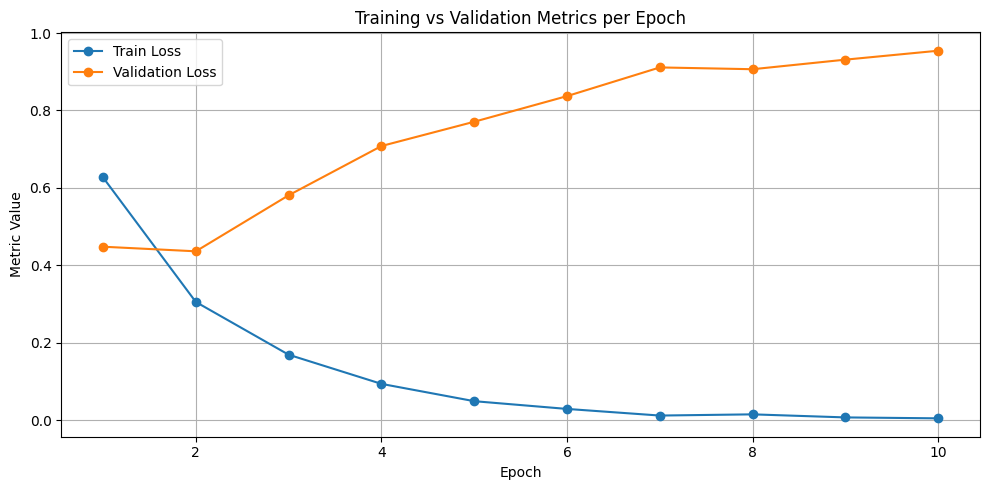

In [ ]:
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(log_df["epoch"], log_df["loss"], label="Train Loss", marker="o")
plt.plot(log_df["epoch"], log_df["eval_loss"], label="Validation Loss", marker="o")

# Plot F1 if available
#if "eval_f1_macro" in log_df.columns:
#    plt.plot(log_df["epoch"], log_df["eval_f1_macro"], label="Validation F1 (Macro)", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training vs Validation Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model begins to overfit after epoch 2, as evidenced by the validation loss increasing while the training loss continues to decrease. This indicates that further training leads to the model memorizing the training data rather than generalizing well. Therefore, limiting fine-tuning to just 2 epochs is optimal for the model (e.g., FinBERT) to prevent overfitting and maintain generalization performance.

In [ ]:
preds_output=trainer.predict(tokenizer_test)
preds=preds_output.predictions.argmax(axis=-1)


- As we did previously, we define a function for later use to make predictions using the fine-tuned FinBERT model trained for just 2 epochs.

In [ ]:
def predict_with_finetuned_finbert(X_train, y_train, X_test):
    # Step 1: Prepare datasets
    train_data = {"text": X_train.tolist(), "label": y_train.tolist()}
    test_data = {"text": X_test.tolist(), "label": [0]*len(X_test)}  # dummy labels
    train_dataset = Dataset.from_dict(train_data)
    test_dataset = Dataset.from_dict(test_data)

    # Step 2: Tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained( "ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    def tokenizer_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length")

    tokenized_train = train_dataset.map(tokenizer_function, batched=True)
    tokenized_test = test_dataset.map(tokenizer_function, batched=True)
    #tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    #tokenized_test.set_format("torch", columns=["input_ids", "attention_mask"])

    # Step 3: Training args
    training_args = TrainingArguments(
        output_dir="./finbert-finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none",
        weight_decay=0.01,
        warmup_steps=50
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro"),
            "precision_macro": precision_score(labels, preds, average="macro"),
            "recall_macro": recall_score(labels, preds, average="macro")
        }
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        compute_metrics=compute_metrics
    )

    trainer.train()
    train_preds = trainer.predict(tokenized_train).predictions.argmax(axis=-1)
    test_preds = trainer.predict(tokenized_test).predictions.argmax(axis=-1)

    return train_preds, test_preds


In [ ]:
_, preds=predict_with_finetuned_finbert(X_train_all, y_train_all, X_test)
print(" Classification on ProsusAI/finbert with finetunning")
print(classification_report(y_test, preds, target_names=labels))

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Step,Training Loss
478,0.594900
956,0.299200


 Classification on ProsusAI/finbert with finetunning
              precision    recall  f1-score   support

     Bearish       0.74      0.74      0.74       288
     Bullish       0.83      0.75      0.78       385
     Neutral       0.91      0.93      0.92      1236

    accuracy                           0.86      1909
   macro avg       0.82      0.81      0.81      1909
weighted avg       0.86      0.86      0.86      1909



#### FinBERT Model Performance Comparison (ProsusAI/finbert)

We evaluated the performance of the `ProsusAI/finbert` model on a financial sentiment classification task using tweets. Below is a **side-by-side comparison** of the metrics **before and after fine-tuning**.

---

- ###### Class-wise Performance

| Metric       | Bullish (No FT) | Bullish (FT) | Bearish (No FT) | Bearish (FT) | Neutral (No FT) | Neutral (FT) |
|--------------|-----------------|--------------|------------------|--------------|------------------|--------------|
| Precision    | 0.59            | 0.83         | 0.46             | 0.74         | 0.85             | 0.91         |
| Recall       | 0.62            | 0.75         | 0.76             | 0.74         | 0.71             | 0.93         |
| F1-score     | 0.60            | 0.78         | 0.57             | 0.74         | 0.77             | 0.92         |
| Support      | 385             | 385          | 288              | 288          | 1236             | 1236         |

---

- ##### Overall Performance

| Metric             | No Fine-Tuning | With Fine-Tuning |
|--------------------|----------------|------------------|
| Accuracy           | 0.70           | **0.86**         |
| Macro Avg F1       | 0.65           | **0.81**         |
| Weighted Avg F1    | 0.71           | **0.86**         |

---

Fine-tuning the `ProsusAI/finbert` model on our labeled tweet dataset significantly improved classification performance:

- **Accuracy** increased from 70% to **86%**
- **Macro F1-score** improved from 0.65 to **0.81**
- **Bullish and Bearish** sentiment detection saw strong improvements in both **precision** and **F1-score**
- **Neutral** tweets were already strong but improved further, especially in recall and F1

These results confirm that fine-tuning a domain-specific model like FinBERT on labeled data can substantially improve performance — especially in **less frequent or more ambiguous sentiment classes**.

**Next Step**: We will repeat this same fine-tuning and evaluation process using [`yiyanghkust/finbert-tone`] to compare its performance against `ProsusAI/finbert`.



#### 4.4.2 Classification with yiyanghkust/finbert-tone

In [ ]:
MODEL_NAME = "yiyanghkust/finbert-tone"

##### 4.4.2.1 Without finetunning

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
print(model.config.id2label)

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}


- Doesn´t match our our since ours is:

In [ ]:
label_map

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

Let's adapt the code of classify_tweet

In [ ]:
def classify_tweet(tweet):
  inputs=tokenizer(tweet, return_tensors="pt", truncation=True, padding=True)
  outputs=model(**inputs)
  logits=outputs.logits
  predictions=torch.nn.functional.softmax(logits, dim=-1)
  #return label_map.index(LABELS[predictions.argmax()])
  model_pred=int(predictions.argmax())
  remap = {0:2, 1:1, 2:0}  # model index to our desired index
  return remap[model_pred]

- Testing it:

In [ ]:
text= "kida shares are crashing!!"
classify_tweet(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0

In [ ]:
preds=X_test.apply(lambda x: classify_tweet(x))

In [ ]:
print("Classification on yiyanghkust/finbert-tone without finetunning")
print(classification_report(y_test,preds, target_names=labels))

Classification on yiyanghkust/finbert-tone without finetunning
              precision    recall  f1-score   support

     Bearish       0.55      0.64      0.59       288
     Bullish       0.59      0.59      0.59       385
     Neutral       0.81      0.78      0.80      1236

    accuracy                           0.72      1909
   macro avg       0.65      0.67      0.66      1909
weighted avg       0.73      0.72      0.72      1909



##### 4.4.2.2 With finetunning

- Tokenizing the text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
def tokenizer_function(example):
  return tokenizer(example["text"],truncation=True, padding="max_length",max_length=128)

tokenizer_train=train_dataset.map(tokenizer_function, batched=True)
tokenizer_val=val_dataset.map(tokenizer_function, batched=True)
tokenizer_test=test_dataset.map(tokenizer_function, batched=True)

#Format for PyTorch
#tokenizer_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
#tokenizer_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
#tokenizer_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/6107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1527 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
training_args=TrainingArguments(
    output_dir="./finbert-finetuned-tone",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch", # Enables evaluation at the end of every epoch
    save_strategy="epoch", # Enables saving at the end of every epoch
    load_best_model_at_end=True, # Enables loading the best model at
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",  # disables wandb, tensorboard, etc.
    weight_decay=0.01,  # ⛓ regularization
    warmup_steps=50 #warmup_steps controls how many initial training steps use a small learning rate, slowly increasing up to your full learning_rate.
)

- Training/finetunning the model

In [ ]:
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenizer_train,
    eval_dataset=tokenizer_val,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.858100,0.434618,0.831041,0.778354,0.779948,0.777078
2,0.315100,0.496551,0.842174,0.799554,0.782056,0.823885
3,0.149800,0.696132,0.857891,0.805261,0.836443,0.780960
4,0.069300,0.964329,0.848068,0.801090,0.800077,0.802214
5,0.032900,1.209749,0.859856,0.811468,0.830774,0.797615
6,0.021300,1.308599,0.845449,0.797697,0.800973,0.795720
7,0.012600,1.294903,0.851343,0.804452,0.810083,0.799839
8,0.008900,1.324370,0.861166,0.814898,0.828838,0.802665
9,0.004300,1.366802,0.857236,0.811358,0.819790,0.804365
10,0.002800,1.361220,0.859201,0.815226,0.818539,0.812779


TrainOutput(global_step=3820, training_loss=0.1475109103774525, metrics={'train_runtime': 472.7408, 'train_samples_per_second': 129.183, 'train_steps_per_second': 8.081, 'total_flos': 4017084105162240.0, 'train_loss': 0.1475109103774525, 'epoch': 10.0})

In [ ]:
training_log=trainer.state.log_history
log_df=pd.DataFrame(training_log)
log_df_eval_loss = log_df[["epoch","eval_loss","eval_f1_macro"]][log_df["eval_loss"].notnull()]
log_df_train_loss = log_df[["epoch","loss"]][log_df["loss"].notnull()]
log_df=pd.merge(log_df_eval_loss, log_df_train_loss, on="epoch")
log_df

,epoch,eval_loss,eval_f1_macro,loss
0,1.0,0.434618,0.778354,0.8581
1,2.0,0.496551,0.799554,0.3151
2,3.0,0.696132,0.805261,0.1498
3,4.0,0.964329,0.801090,0.0693
4,5.0,1.209749,0.811468,0.0329
5,6.0,1.308599,0.797697,0.0213
6,7.0,1.294903,0.804452,0.0126
7,8.0,1.324370,0.814898,0.0089
8,9.0,1.366802,0.811358,0.0043
9,10.0,1.361220,0.815226,0.0028


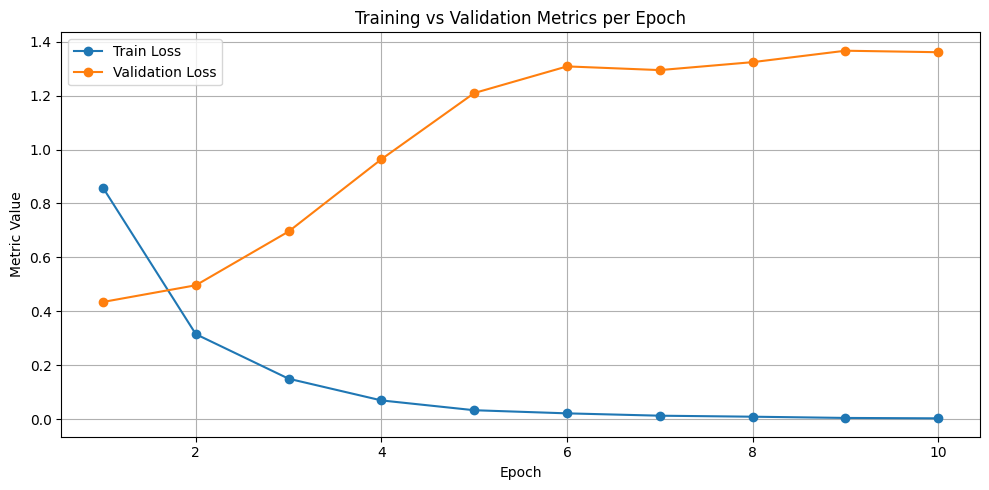

In [ ]:
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(log_df["epoch"], log_df["loss"], label="Train Loss", marker="o")
plt.plot(log_df["epoch"], log_df["eval_loss"], label="Validation Loss", marker="o")

# Plot F1 if available
#if "eval_f1_macro" in log_df.columns:
#    plt.plot(log_df["epoch"], log_df["eval_f1_macro"], label="Validation F1 (Macro)", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training vs Validation Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model begins to overfit after epoch 2, as evidenced by the validation loss increasing while the training loss continues to decrease. This indicates that further training leads to the model memorizing the training data rather than generalizing well. Therefore, limiting fine-tuning to just 2 epochs is optimal for the model Finbert-tone to prevent overfitting and maintain generalization performance.

In [ ]:
preds_output=trainer.predict(tokenizer_test)
preds=preds_output.predictions.argmax(axis=-1)
print(classification_report(y_test,preds,target_names=LABELS))

              precision    recall  f1-score   support

     Bullish       0.72      0.78      0.75       288
     Bearish       0.83      0.80      0.81       385
     Neutral       0.91      0.90      0.91      1236

    accuracy                           0.86      1909
   macro avg       0.82      0.83      0.82      1909
weighted avg       0.87      0.86      0.87      1909



- As we did previously, we define a function for later use to make predictions using the fine-tuned FinBERT-tone model trained for just 2 epochs.

In [ ]:
def predict_with_finetuned_finbert_tone(X_train, y_train, X_test):
    # Step 1: Prepare datasets
    train_data = {"text": X_train.tolist(), "label": y_train.tolist()}
    test_data = {"text": X_test.tolist(), "label": [0]*len(X_test)}  # dummy labels
    train_dataset = Dataset.from_dict(train_data)
    test_dataset = Dataset.from_dict(test_data)

    # Step 2: Tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(  "yiyanghkust/finbert-tone")
    model = AutoModelForSequenceClassification.from_pretrained( "yiyanghkust/finbert-tone")

    def tokenizer_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

    tokenized_train = train_dataset.map(tokenizer_function, batched=True)
    tokenized_test = test_dataset.map(tokenizer_function, batched=True)

    # Step 3: Training args
    training_args = TrainingArguments(
        output_dir="./finbert-finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        logging_strategy="epoch",
        save_strategy="no",
        report_to="none",
        weight_decay=0.01,
        warmup_steps=50
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro"),
            "precision_macro": precision_score(labels, preds, average="macro"),
            "recall_macro": recall_score(labels, preds, average="macro")
        }
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        compute_metrics=compute_metrics
    )

    trainer.train()
    train_preds = trainer.predict(tokenized_train).predictions.argmax(axis=-1)
    test_preds = trainer.predict(tokenized_test).predictions.argmax(axis=-1)

    return train_preds, test_preds

In [ ]:
_, preds=predict_with_finetuned_finbert_tone(X_train_all, y_train_all, X_test)
print(" Classification on yiyanghkust/finbert-tone with finetunning")
print(classification_report(y_test, preds, target_names=labels))

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Step,Training Loss
478,0.781900
956,0.279900


 Classification on yiyanghkust/finbert-tone with finetunning
              precision    recall  f1-score   support

     Bearish       0.74      0.73      0.73       288
     Bullish       0.82      0.79      0.80       385
     Neutral       0.90      0.91      0.91      1236

    accuracy                           0.86      1909
   macro avg       0.82      0.81      0.81      1909
weighted avg       0.86      0.86      0.86      1909



#### Model Performance Comparison FinBERT-Tone (`yiyanghkust/finbert-tone`)

We evaluated the model `yiyanghkust/finbert-tone` on our financial tweet sentiment classification task. Below are the results **before and after fine-tuning** on our labeled dataset.

---

- ##### Class-wise Performance

| Metric       | Bullish (No FT) | Bullish (FT) | Bearish (No FT) | Bearish (FT) | Neutral (No FT) | Neutral (FT) |
|--------------|-----------------|--------------|------------------|--------------|------------------|--------------|
| Precision    | 0.59            | 0.82         | 0.55             | 0.74         | 0.81             | 0.90         |
| Recall       | 0.59            | 0.79         | 0.64             | 0.73         | 0.78             | 0.91         |
| F1-score     | 0.59            | 0.80         | 0.59             | 0.73         | 0.80             | 0.91         |
| Support      | 385             | 385          | 288              | 288          | 1236             | 1236         |

---

- ##### Overall Performance

| Metric             | No Fine-Tuning | With Fine-Tuning |
|--------------------|----------------|------------------|
| Accuracy           | 0.72           | **0.86**         |
| Macro Avg F1       | 0.66           | **0.81**         |
| Weighted Avg F1    | 0.72           | **0.86**         |

---

- ##### Finetuned Model Comparison – ProsusAI vs. FinBERT-Tone

| Metric             | `ProsusAI/finbert` | `yiyanghkust/finbert-tone` |
|--------------------|--------------------|-----------------------------|
| Accuracy           | 0.86               | **0.86**                    |
| Macro Avg F1       | 0.81               | **0.81**                    |
| Weighted Avg F1    | 0.86               | **0.86**                    |

---




##### Final Thoughts on FinBERT Models

We fine-tuned two domain-specific transformer models:

- `ProsusAI/finbert`
- `yiyanghkust/finbert-tone`

Both models showed **significant improvements** after fine-tuning and achieved **very similar overall performance**:
- **Accuracy**: 86%
- **Macro F1**: 0.81
- **Weighted F1**: 0.86

`yiyanghkust/finbert-tone` performed slightly better in **neutral** and **bullish** classes, while `ProsusAI/finbert` had similar performance for **bearish** sentiment.

These results confirm that **fine-tuning domain-specific models** on labeled financial data is highly effective, even when the base models differ slightly in architecture or training.

**Next Step**: We will now explore **generative language models**, such as `GPT-4`, to test **zero-shot and few-shot classification** using prompt-based approaches. This will allow us to evaluate how well large generative models perform without additional training on financial sentiment tasks.


### 6. Classification with Generative Models


In this chapter, we explore a completely different paradigm for tweet sentiment classification — using Generative AI models like ChatGPT.

Unlike traditional supervised learning, which requires labeled training data and fitting a model, generative models can classify text through prompt-based interaction.

In this approach, We provide a few manually labeled examples per class (Bullish, Bearish, Neutral) — this is called few-shot prompting. Then, we ask ChatGPT to classify new tweets based on those examples. This method requires no training or fine-tuning, we simply leverage the powerful reasoning and pattern-recognition capabilities of models like gpt-3.5-turbo through well-designed prompts.

After that, we only evaluate on the final test set to simulate real-world usage where the generative model is used as classifier.

This gives us a new perspective: instead of training, we’re testing whether a general-purpose large language model can perform comparably to our fine-tuned and traditional ML models — simply by "understanding" the task via instructions.

pip install --upgrade openai

In [ ]:
from google.colab import userdata

In [ ]:
api_key = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [ ]:
label_map

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

In [ ]:
label_id={v:k for k,v in label_map.items()}

In [ ]:
label_id

{'Bearish': 0, 'Bullish': 1, 'Neutral': 2}

In [ ]:
def build_few_shot_examples(X_train, y_train, max_per_class=10):
    # Combine into a DataFrame
    df = pd.DataFrame({"text": X_train, "label": y_train})
    df = shuffle(df, random_state=42)
    #df = shuffle(df)

    few_shot_examples = []

    for label_id, label_name in label_map.items():
        subset = df[df["label"] == label_id].sample(n=max_per_class, random_state=42)
        for _, row in subset.iterrows():
            few_shot_examples.append({
                "tweet": row["text"],
                "label": label_name
            })

    return few_shot_examples

In [ ]:
few_shot_examples = build_few_shot_examples(X_train, y_train, max_per_class=10)
few_shot_examples


[{'tweet': 'walmart inc.s jet subsidiary is ending its fresh-food delivery business just a year after introducing the service',
  'label': 'Bearish'},
 {'tweet': 'coronavirus task force declares public health emergency',
  'label': 'Bearish'},
 {'tweet': 'energy down with energy futures -- energy roundup nymex stock marketscreener',
  'label': 'Bearish'},
 {'tweet': 'intelsat shorts stick to positions even after record 75 % wipeout',
  'label': 'Bearish'},
 {'tweet': 'wwe stock price target cut to $ 57 from $ 79 at benchmark',
  'label': 'Bearish'},
 {'tweet': 'and now we sell', 'label': 'Bearish'},
 {'tweet': 'nintendo switch shipments to japan delayed by coronavirus',
  'label': 'Bearish'},
 {'tweet': 'lagarde says ecb running out of room to fight global threats',
  'label': 'Bearish'},
 {'tweet': 'brixmor 2020 ffo guidance comes in on the light side',
  'label': 'Bearish'},
 {'tweet': '$ asln $ kzia $ xxii - kl , cbay among premarket losers',
  'label': 'Bearish'},
 {'tweet': 'deuts

In [ ]:
def classify_with_chatgpt_fewshot(tweet, examples, model="gpt-3.5-turbo", temperatue=0.0):

  system_prompt=(
      "You are a finacial analyst that classifies tweets into: Bullish, Bearish, or Neutral."
      "Respond with only one label per tweet."
  )

  messages=[{"role": "system", "content": system_prompt}]
  for example in examples:
    messages.append({"role": "user", "content": example["tweet"]})
    messages.append({"role": "assistant", "content": example["label"]})

  messages.append({"role": "user", "content": tweet})

  response = client.chat.completions.create(
      model=model,
      messages=messages,
      temperature=temperatue
  )

  return response.choices[0].message.content.strip()


- Testing with some tweets

In [ ]:
preds=[]
for tweet , true_label in zip(X_test[:5], y_test[:5]):
  label=classify_with_chatgpt_fewshot(tweet, few_shot_examples)
  #preds.append(label)
  label=label.capitalize().strip()
  print("Tweet: ", tweet)
  print("True label",label_map[true_label])
  print("Gpt label: ", label)
  if label not in labels:
    label="Neutral"
  preds.append(label_id[label])


Tweet:  i love it when fertility clinic 's decorate ...... and it 's not even thanks giving ..... i.e . premature
True label Neutral
Gpt label:  Neutral
Tweet:  irs investigators scrutinize bitcoin atms and kiosks
True label Neutral
Gpt label:  Neutral
Tweet:  $ srpt higher by 4.5 % today clearing 21 ma and nearing feb opex value range breakout
True label Bullish
Gpt label:  Bullish
Tweet:  wells fargo downgrades netflix on spending concerns
True label Bearish
Gpt label:  Neutral
Tweet:  docusign signs off on another solid earnings result $ docu
True label Bullish
Gpt label:  Neutral


- Now lets try in batch

In [ ]:
def classify_batch_with_chatgpt(tweets, examples, model="gpt-3.5-turbo"):
    system_prompt = (
        "You are a financial analyst that classifies tweets into: Bullish, Bearish, or Neutral.\n"
        "Given multiple tweets, return one label per tweet in the same order, each on a new line."
    )

    messages = [{"role": "system", "content": system_prompt}]
    for ex in examples:
        messages.append({"role": "user", "content": ex["tweet"]})
        messages.append({"role": "assistant", "content": ex["label"]})

    # Add all tweets as a single user message
    joined_tweets = "\n".join([f"{i+1}. {tweet}" for i, tweet in enumerate(tweets)])
    messages.append({
        "role": "user",
        "content": f"Classify the following tweets:\n{joined_tweets}"
    })

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0.0
    )

    result = response.choices[0].message.content.strip()
    return [line.strip().capitalize() for line in result.splitlines()]


In [ ]:
def clean_label(raw_label):
    # Remove any numbering like "1. ", "2)", etc., and clean up casing and whitespace
    label = re.sub(r"^\s*\d+[\.\)]?\s*", "", raw_label).strip().capitalize()
    if label not in labels:
        label = "Neutral"
    return label

- Lets test the request in batch

In [ ]:
batch_size = 15  # or 5/20 depending on cost tolerance
preds = []
true_labels = []

for i in range(0, 15, batch_size):
    batch_tweets = list(X_test[i:i + batch_size])
    batch_true = list(y_test[i:i + batch_size])

    batch_preds = classify_batch_with_chatgpt(batch_tweets, few_shot_examples)

    for tweet, true_label, raw_pred in zip(batch_tweets, batch_true, batch_preds):
        pred_label =   clean_label(raw_pred)

        if pred_label not in labels:
            pred_label = "Neutral"

        preds.append(label_id[pred_label])
        true_labels.append(true_label)


- Now lets create a function to predict with chatgpt for later use

In [ ]:
def predict_with_chatgpt(X_train, y_train, X_test, label_map, api_key, batch_size=15, model="gpt-3.5-turbo"):
    client = OpenAI(api_key=api_key)
    label_id = {v: k for k, v in label_map.items()}
    LABELS = list(label_id.keys())

    def build_few_shot_examples(X_train, y_train, max_per_class=10):
        df = pd.DataFrame({"text": X_train, "label": y_train})
        df = shuffle(df, random_state=42)
        few_shot_examples = []

        for id_, label in label_map.items():
            subset = df[df["label"] == id_].sample(n=max_per_class, random_state=42)
            for _, row in subset.iterrows():
                few_shot_examples.append({"tweet": row["text"], "label": label})

        return few_shot_examples

    def classify_batch_with_chatgpt(tweets, examples):
        system_prompt = (
            "You are a financial analyst that classifies tweets into: Bullish, Bearish, or Neutral.\n"
            "Given multiple tweets, return one label per tweet in the same order, each on a new line."
        )

        messages = [{"role": "system", "content": system_prompt}]
        for ex in examples:
            messages.append({"role": "user", "content": ex["tweet"]})
            messages.append({"role": "assistant", "content": ex["label"]})

        joined_tweets = "\n".join([f"{i+1}. {tweet}" for i, tweet in enumerate(tweets)])
        messages.append({
            "role": "user",
            "content": f"Classify the following tweets:\n{joined_tweets}"
        })

        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.0
        )

        result = response.choices[0].message.content.strip()
        return [line.strip().capitalize() for line in result.splitlines()]

    def clean_label(raw_label):
        label = re.sub(r"^\s*\d+[\.\)]?\s*", "", raw_label).strip().capitalize()
        return label if label in LABELS else "Neutral"

    few_shot_examples = build_few_shot_examples(X_train, y_train)

    preds = []
    for i in range(0, len(X_test), batch_size):
        batch_tweets = list(X_test[i:i + batch_size])
        batch_preds = classify_batch_with_chatgpt(batch_tweets, few_shot_examples)

        for raw_pred in batch_preds:
            pred_label = clean_label(raw_pred)
            if pred_label not in labels:
              pred_label = "Neutral"
            preds.append(label_id[pred_label])

    # dummy for train predictions (ChatGPT doesn't use train)
    train_preds = [-1] * len(X_train)

    return train_preds, preds


In [ ]:
_, preds=predict_with_chatgpt(X_train_all, y_train_all, X_test, label_map, api_key, batch_size=15, model="gpt-3.5-turbo")
print(" Classification on gpt-3.5-turbo")
print(classification_report(y_test, preds, target_names=labels))

 Classification on gpt-3.5-turbo
              precision    recall  f1-score   support

     Bearish       0.69      0.67      0.68       288
     Bullish       0.75      0.65      0.70       385
     Neutral       0.83      0.86      0.84      1236

    accuracy                           0.79      1909
   macro avg       0.75      0.73      0.74      1909
weighted avg       0.79      0.79      0.79      1909



We evaluated several models for financial tweet sentiment classification using a mix of traditional ML, fine-tuned transformers, and generative models. Below is a summary and key conclusions based on performance on the test set.

---

##### Summary of Results (Overall)

| Model                         | Accuracy | Macro F1 | Weighted F1 |
|------------------------------|----------|----------|--------------|
| E5-Base + MLP                | 0.83     | 0.79     | 0.83         |
| MPNet + MLP                  | 0.85     | 0.80     | 0.85         |
| ProsusAI/finbert (FT)        | 0.86     | 0.81     | 0.86         |
| FinBERT-Tone (FT)            | 0.86     | 0.81     | 0.86         |
| GPT-3.5 Turbo (few-shot)     | 0.79     | 0.74     | 0.79         |



##### Per-Class F1-score Comparison

| Model                         | Bearish | Bullish | Neutral |
|------------------------------|---------|---------|---------|
| E5-Base + MLP                | 0.72    | 0.76    | 0.88    |
| MPNet + MLP                  | 0.72    | 0.79    | 0.90    |
| ProsusAI/finbert (FT)        | **0.74**| 0.78    | **0.92**|
| FinBERT-Tone (FT)            | 0.73    | **0.80**| 0.91    |
| GPT-3.5 Turbo (few-shot)     | 0.68    | 0.70    | 0.84    |



##### Best Model Per Class

- **Bearish**: `ProsusAI/finbert` (F1 = **0.74**)
- **Bullish**: `FinBERT-Tone` (F1 = **0.80**)
- **Neutral**: `ProsusAI/finbert` (F1 = **0.92**)

- **Fine-tuned transformer models (FinBERT variants)** outperformed all others across all metrics and sentiment classes.
- **ProsusAI/finbert** stands out with the **best performance for Bearish and Neutral** tweets.
- **FinBERT-Tone** slightly edges out others on **Bullish** sentiment, which is often more subtle and context-dependent.
- **MPNet + MLP** is a solid choice among traditional ML setups, offering good performance, especially on Neutral and Bullish.
- **GPT-3.5 Turbo**, while decent for a zero/few-shot model, still lags behind fine-tuned models, particularly for Bearish and Bullish detection.

